In [1]:
%load_ext autoreload
%autoreload 2

print 'Finished!'


Finished!


In [4]:

# standard libraries
from datetime import datetime

# nonstandard libraries
import numpy as np

# homegrown libraries
from methods import * # libraries: madhype,alphabetr,pairseq
from graphers import * # libraries: graphical_tools
from datasim import * # libraries: seq_data,seq_generator

print 'Finished!'


Finished!


In [5]:

def assess_performance(results,data):
    pairs = results['cells']

    cells = data.metadata['cells']
    all_alphas, all_betas = zip(*cells)
    all_alphas,all_betas = set(all_alphas),set(all_betas)

    obs_alphas, obs_betas = zip(*data.well_data)
    obs_alphas, obs_betas = set(sum(obs_alphas, [])), set(sum(obs_betas, []))

    cells_set = set([(a,b) for a,b in cells])
    correct_pairs = [p for p in pairs if p in cells_set]
    incorrect_pairs = [p for p in pairs if p not in cells_set]

    pair_idxs = [cells.index(p) if p in cells else -1 for p in pairs]
    actual_freqs = [data.metadata['generated_data']['cell_frequencies'][i] if i!=-1 else 0.0 for i in pair_idxs]
    pred_freqs = results['cell_frequencies']
    pred_freqs_CI = results['cell_frequencies_CI']
    
    print "Solution statistics:"
    print "  Total cells (in system):", len(cells)
    print "  Number of alpha chains (in system):", len(all_alphas)
    print "  Number of beta chains (in system):", len(all_betas)
    print "  Number of alpha chains (observed):", len(obs_alphas)
    print "  Number of beta chains (observed):", len(obs_betas)
    print "  Total pairs identified:", len(pairs)
    print "  Correct pairs identified: {0} ({1}%)".format(len(correct_pairs), 100.*len(correct_pairs)/len(cells))
    print "  Incorrect pairs identified: {0}".format(len(incorrect_pairs))
    print "  False discovery rate: {0}%".format(100.*len(incorrect_pairs)/len(pairs))
    print "  Mean squared error of frequency guesses: {0}".format(np.mean([(f1-f2)**2 for f1,f2 in zip(actual_freqs, pred_freqs)]))

print 'Finished!'

Finished!


In [7]:

'''
Generate landscapes
'''

gen = seq_generator.SequencingGenerator()

'''
Set distributions
'''

w_tot = 96

gen.set_cell_frequency_distribution('power-law', alpha=-1)
gen.set_options(chain_misplacement_prob=0,chain_deletion_prob=10**-1)
#gen.chain_misplacement_prob = 10**5 # Prob of a chain migrating to another well
#gen.chain_deletion_prob = 10**5 # Prob of a chain failing to be amplified

gen.num_wells = w_tot

# Make SequencingGenerator object
gen.set_cells_per_well('constant', cells_per_well=50)
#gen.set_cells_per_well('poisson', lam=100)

#gen.cells = SeqGen.generate_cells_lee(600)
gen.cells = gen.generate_cells(200)
#cells += SeqGen.generate_cells(250, 2, 1, alpha_start_idx=250, beta_start_idx=251) 
#cells += SeqGen.generate_cells(250, 1, 2, alpha_start_idx=2000, beta_start_idx=2000) 
#gen.cells = cells

## Save data to a file
data = gen.generate_data()
data.save_data('patrick_testing.txt')

print 'Finished!'

Finished!


In [10]:
print data.well_data[0]
print data.metadata['cells']

[[11, 16, 25, 29, 33, 38, 56, 62, 66, 71, 74, 80, 83, 92, 93, 95, 99, 100, 115, 123], [5, 10, 11, 13, 39, 52, 60, 65, 69, 73, 83, 84, 86, 98, 105, 115, 123, 140, 142, 144, 146, 150]]
[((109,), (36,)), ((55,), (160,)), ((95,), (159,)), ((55,), (58,)), ((108,), (2,)), ((123,), (86,)), ((95,), (121,)), ((46,), (116,)), ((54,), (101,)), ((15,), (120,)), ((55,), (75,)), ((97,), (64,)), ((28,), (89,)), ((111,), (22,)), ((101,), (66,)), ((70,), (40,)), ((113,), (72,)), ((120,), (84,)), ((45,), (65,)), ((27,), (153,)), ((34,), (45,)), ((66,), (94,)), ((110,), (60,)), ((74,), (97,)), ((100,), (140,)), ((82,), (52,)), ((101,), (132,)), ((101,), (73,)), ((23,), (6,)), ((8,), (113,)), ((69,), (95,)), ((62,), (83,)), ((105,), (77,)), ((75,), (16,)), ((93,), (13,)), ((74,), (30,)), ((77,), (129,)), ((49,), (79,)), ((12,), (50,)), ((74,), (87,)), ((118,), (156,)), ((118,), (127,)), ((107,), (103,)), ((85,), (134,)), ((10,), (139,)), ((56,), (144,)), ((50,), (152,)), ((26,), (130,)), ((87,), (138,)), 

In [ ]:
from methods import * # libraries: madhype,alphabetr,pairseq


#startTime = datetime.now()
#new_results = madhype.solve(data,pair_threshold=0.9,verbose=2) # not stringent
#print 'MAD-HYPE took {} seconds.\n'.format(datetime.now()-startTime)

#startTime = datetime.now()
#lee_results = alphabetr.solve(data,pair_threshold=0.1) # not stringent
#print 'Lee took {} seconds.\n'.format(datetime.now()-startTime)

startTime = datetime.now()
lee_results = pairseq.solve(data,pair_threshold=0.1) # not stringent
print 'Howie took {} seconds.\n'.format(datetime.now()-startTime)

#print '\nMAD-HYPE Performance:'
#assess_performance(new_results,data)

#print '\nLEE Performance:'
#assess_performance(lee_results,data)

methods/pairseq.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return nCk(C,c)*(f**c)*((1-f)**(C-c))


In [6]:
print data.metadata['cells_per_well_distribution_params']['cells_per_well']
print data.metadata['num_wells']

NameError: name 'data' is not defined

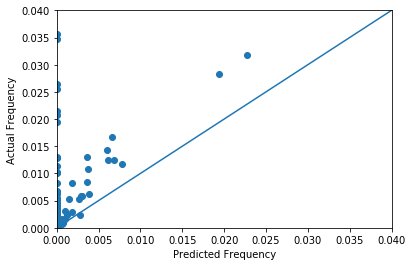

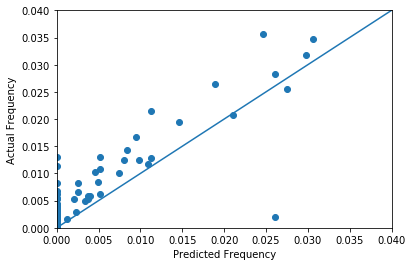

In [39]:

import matplotlib.pyplot as plt

def grapher(results,mod=True):
    predicted_freq = []

    cells_per_well = data.metadata['cells_per_well_distribution_params']['cells_per_well']
    wells = data.metadata['num_wells']

    for (a,),(b,) in data.metadata['cells']:
        c = (a,b)
        if c in results['cells']:
            val = results['cell_frequencies'][results['cells'].index(c)]
            if mod: predicted_freq.append(1 - ((1-val)**(1./cells_per_well)))
            else: predicted_freq.append(val)
        else:
            predicted_freq.append(0.)

    plt.scatter(predicted_freq,data.metadata['generated_data']['cell_frequencies'])
    plt.plot(np.arange(0,.1,.01),np.arange(0,.1,.01))
    plt.xlabel('Predicted Frequency')
    plt.ylabel('Actual Frequency')
    plt.xlim((0.,0.04))
    plt.ylim((0.,0.04))
    plt.show()

grapher(new_results,True)
grapher(lee_results,False)
